# Trajectory Arrows

Draw arrows along the main trajectories. Based on `20201025_trajectory_viz/TrajViz.ipynb`

Inputs:
1. Metadata for ATAC
2. Cluster config
3. Pseudotime

In [26]:
library(ggplot2)
library(scattermore)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

## Load Inputs

### ATAC MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) 
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 62599     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1,D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1,D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1,D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1,D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3,D0_AAACCCTGATTGCAGT


### Cluster Config

In [6]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster,colour,description,new_cluster
<int>,<fct>,<fct>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially-reprogrammed,10


In [7]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

### ATAC Pseudotime

In [8]:
pseudotime = read.table("../../analysis/20200217_trajectory/sessions/20211003_n62599/pseudotime.tsv")
rownames(pseudotime) = pseudotime$sample_barcode
pseudotime$sample_barcode = NULL
all(rownames(pseudotime) == rownames(metaData))
head(pseudotime)

[1] TRUE

,dpt_pseudotime_fibr,dpt_pseudotime_high_OSK
,<dbl>,<dbl>
D0_AAACACGCTAGTACGG,0.00000000,0.8747373
D0_AAACACGCTCTTCAAG,0.03884950,0.8782327
D0_AAACACGCTGATCCAT,0.10171443,0.8466607
D0_AAACCCTGACCGCTAG,0.09229346,0.8495939
D0_AAACCCTGATTGCAGT,0.05027944,0.8626735
D0_AAACCGTACACACCTA,0.03454594,0.8612965


## Plot

In [50]:
# for the trajectories, choose pseudotime computed using either fibroblast cell as starting point
# or high OSK cell as starting point
ALL_PATHS = list(list(c(1,2,3,4,5), "dpt_pseudotime_fibr"), # non reprog
                list(c(8,11,12,13,14), "dpt_pseudotime_high_OSK"), # main
                list(c(7,9,10), "dpt_pseudotime_high_OSK"))# partial
#                 c(1,7,11,12,13,14)) #reprog


COLS = c("tomato", "purple", "blue", "black")

In [51]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5, alpha=1) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_scattermore(pointsize=6.5, aes(x=x , y=y, col=cluster), alpha=alpha, pixels=c(5000,5000)) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()
}

In [58]:
path_plot <- plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id),
                         alpha=0.2,
                        sz=0.25) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) +
ggtitle("Main Trajectories") +
theme(legend.position="none",  plot.title=element_text(size=18)) 

for (i in seq(length(ALL_PATHS))) {
    selected = which(metaData$cluster_new_id %in% ALL_PATHS[[i]][[1]])
    path.df <- data.frame(x = smooth.spline(metaData$umap1[selected][order(pseudotime[selected,ALL_PATHS[[i]][[2]]])], df=200, spar=1)$y, 
                        y = smooth.spline(metaData$umap2[selected][order(pseudotime[selected,ALL_PATHS[[i]][[2]]])], df=200, spar=1)$y)
    
    path_plot = path_plot + 
        geom_path(data=path.df, 
                  aes(x, y), 
                  size=1.5,
                  alpha=.8,
                  color=COLS[i], 
                  arrow=arrow(type="closed",
                              length=unit(.02, "npc")))
} 

In [59]:
# add annotations
# TXTSZ = 5

# path_plot = path_plot 
#             annotate("text", size=TXTSZ, x=7,y=7, label="Reprogramming") +
#             annotate("text", size=TXTSZ, x=3,y=2, label="Fibroblast-like") +
#             annotate("text", size=TXTSZ, x= -7,y= -6.5, label="Keratinocyte-like") +
#             annotate("text", size=TXTSZ, x= -12, y=-2, label="High OSKM")

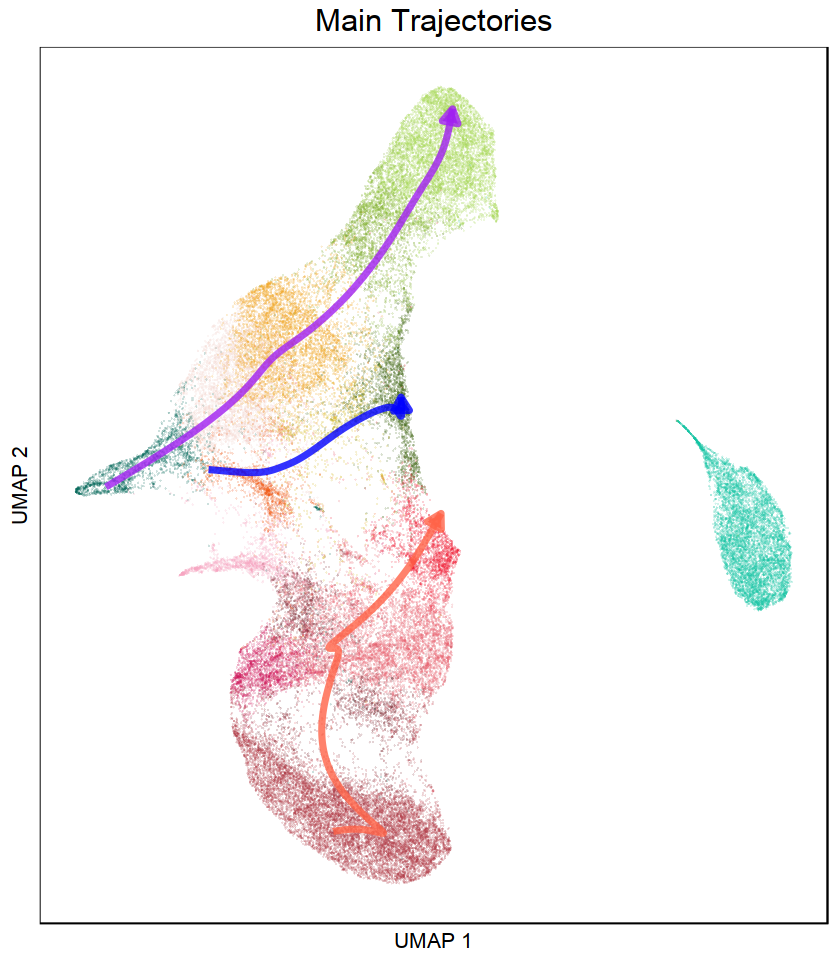

In [60]:
options(repr.plot.width = 7, repr.plot.height = 8)

path_plot

In [61]:
ggsave(path_plot, file=sprintf("./subfigs/%s_traj_arrows.pdf",
                                   format(Sys.Date(), "%Y%m%d")),
       width=7,height=8,
      useDingbats=F)

In [62]:
# saveRDS(path_plot, file=sprintf("./subfigs/%s_traj_arrows.rds",
#                                    format(Sys.Date(), "%Y%m%d")))

---

In [15]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.3

loaded via a namespace (and not attached):
 [1] magrittr_1.5      tidyselect_1.1.0  munsell_0.5.0     uuid_0.1-4       
 [5] colorspace_1.4-1  R6_2.4.1          rlang_0.4.11      dplyr_1.0.2      
 [9] tools_3.6.3       grid_3.6.3        gtable_0.3.0      withr_2.1.2      
[13] h